In [1]:
import numpy as np
import xarray as xr

import ecco_v4_py as ecco
from xhistogram.xarray import histogram
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
from dask.distributed import Client
client = Client(scheduler_file='/mnt/efs/dask-scheduler.json')

### Load datasets

In [4]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')
coords = main.coords.to_dataset().reset_coords()

In [5]:
budgSln = xr.open_zarr('/mnt/efs/data/ecco/zarr/anom/')

### Anomaly budget terms

In [6]:
#### Eularian
# Convergence of mean advection of anomaleous salinity, Eularian (psu m^3/s)
adv_Ueclim_Sanom = budgSln.hadv_Ueclim_Sanom+budgSln.vadv_Ueclim_Sanom

# Convergence of anomaleous advection of mean salinity, Eularian (psu m^3/s)
adv_Ueanom_Sclim = budgSln.hadv_Ueanom_Sclim+budgSln.vadv_Ueanom_Sclim
    
# Convergence of nonlinear salinity advection, Eularian (psu m^3/s)
adv_Ueanom_Sanom = budgSln.hadv_Ueanom_Sanom+budgSln.vadv_Ueanom_Sanom
    
    
#### Bolus
# Convergence of mean advection of anomaleous salinity, Bolus (psu m^3/s)
adv_Ubclim_Sanom = budgSln.hadv_Ubclim_Sanom+budgSln.vadv_Ubclim_Sanom

# Convergence of anomaleous advection of mean salinity, Bolus (psu m^3/s)
adv_Ubanom_Sclim = budgSln.hadv_Ubanom_Sclim+budgSln.vadv_Ubanom_Sclim

# Convergence of nonlinear salinity advection, Bolus (psu m^3/s)
adv_Ubanom_Sanom = budgSln.hadv_Ubanom_Sanom+budgSln.vadv_Ubanom_Sanom


### Volume effect
# Convergence of mean advection of anomaleous salinity, Volume effect (psu m^3/s)
adv_ConvVclim_Sanom = budgSln.hadv_ConvVclim_Sanom+budgSln.vadv_ConvVclim_Sanom

# Convergence of anomaleous advection of mean salinity, Volume effect (psu m^3/s)
adv_ConvVanom_Sclim = budgSln.hadv_ConvVanom_Sclim+budgSln.vadv_ConvVanom_Sclim
    
# Convergence of nonlinear salinity advection, Volume effect (psu m^3/s)
adv_ConvVanom_Sanom = budgSln.hadv_ConvVanom_Sanom+budgSln.vadv_ConvVanom_Sanom


# Convergence of Eularian advection (psu m^3/s)
adv_ConvSe = adv_Ueclim_Sanom + adv_Ueanom_Sclim + adv_Ueanom_Sanom

# Convergence of Bolus advection (psu m^3/s)
adv_ConvSb = adv_Ubclim_Sanom + adv_Ubanom_Sclim + adv_Ubanom_Sanom

# Convergence of Volume effect (psu m^3/s)
adv_ConvVS = adv_ConvVclim_Sanom + adv_ConvVanom_Sclim + adv_ConvVanom_Sanom


# Convergence of total advection (psu m^3/s)
adv_ConvS = adv_ConvSe + adv_ConvSb + adv_ConvVS

# Diffusion (psu m^3/s)
dif_ConvS = budgSln.hdif + budgSln.vdif

### Residual

In [7]:
res_closed = np.abs(adv_ConvS + dif_ConvS + budgSln.frcSln + budgSln.res - budgSln.tnd)
res_closed.name = 'Residual_closed'

res_offline = np.abs(adv_ConvS + dif_ConvS + budgSln.frcSln - budgSln.tnd)
res_offline.name = 'Residual_offline'

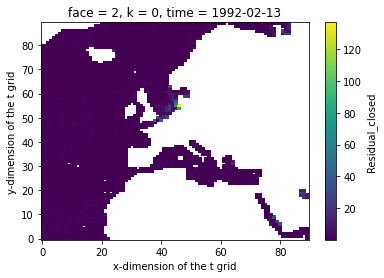

In [13]:
res_closed[1,2,0].plot()

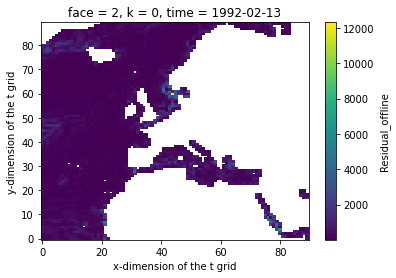

In [14]:
res_offline[1,2,0].plot()

/usr/local/lib/python3.6/dist-packages/ecco_v4_py/plot_utils.py:39: RuntimeWarning: All-NaN axis encountered
  cmin = np.nanmin(fld)
/usr/local/lib/python3.6/dist-packages/ecco_v4_py/plot_utils.py:40: RuntimeWarning: All-NaN axis encountered
  cmax = np.nanmax(fld)
/usr/local/lib/python3.6/dist-packages/ecco_v4_py/plot_utils.py:39: RuntimeWarning: All-NaN axis encountered
  cmin = np.nanmin(fld)
/usr/local/lib/python3.6/dist-packages/ecco_v4_py/plot_utils.py:40: RuntimeWarning: All-NaN axis encountered
  cmax = np.nanmax(fld)


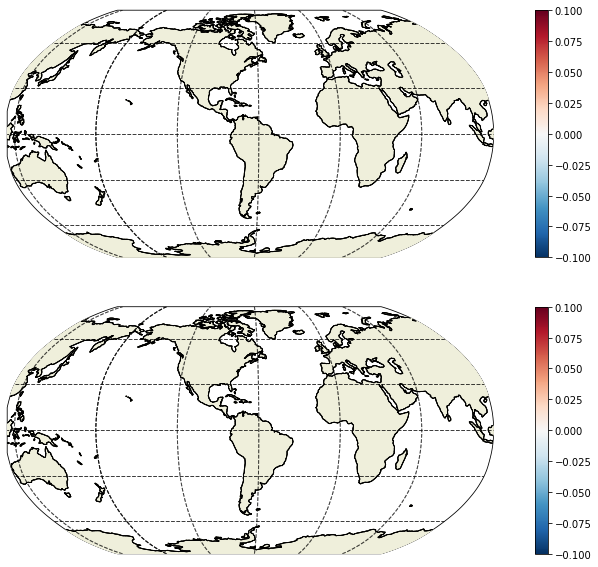

In [29]:
plt.figure(figsize=(15,10))
for idx, res in enumerate([res_closed,res_offline]):
    p = ecco_py.plot_proj_to_latlon_grid(coords.XC, coords.YC, res[-1,:,0], show_colorbar=True,
                                         cmin=-1e-8, cmax=1e-8, cmap='RdBu_r', 
                                         user_lon_0=-67, dx=2, dy=2, subplot_grid=[2,1,idx+1])

/usr/local/lib/python3.6/dist-packages/ecco_v4_py/plot_utils.py:39: RuntimeWarning: All-NaN axis encountered
  cmin = np.nanmin(fld)
/usr/local/lib/python3.6/dist-packages/ecco_v4_py/plot_utils.py:40: RuntimeWarning: All-NaN axis encountered
  cmax = np.nanmax(fld)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1062: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


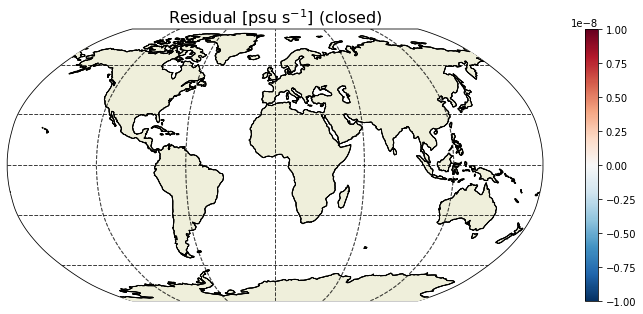

In [33]:
plt.figure(figsize=(15,5))
ecco_py.plot_proj_to_latlon_grid(coords.XC, coords.YC, res_closed[-1,:,0],
                                 cmin=-1e-8, cmax=1e-8, show_colorbar=True, cmap='RdBu_r',dx=0.2, dy=0.2)
plt.title(r'Residual [psu s$^{-1}$] (closed)', fontsize=16)
plt.show()

/usr/local/lib/python3.6/dist-packages/ecco_v4_py/plot_utils.py:39: RuntimeWarning: All-NaN axis encountered
  cmin = np.nanmin(fld)
/usr/local/lib/python3.6/dist-packages/ecco_v4_py/plot_utils.py:40: RuntimeWarning: All-NaN axis encountered
  cmax = np.nanmax(fld)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1062: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


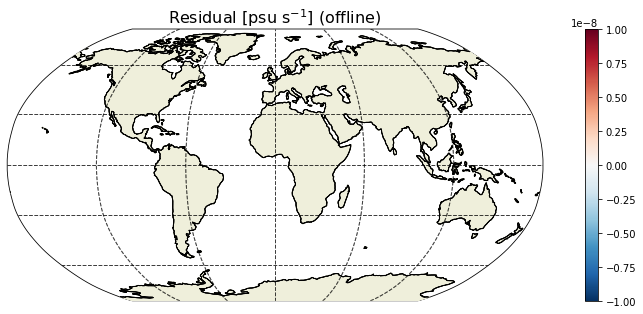

In [34]:
plt.figure(figsize=(15,5))
ecco_py.plot_proj_to_latlon_grid(coords.XC, coords.YC, res_offline[-1,:,0],
                                 cmin=-1e-8, cmax=1e-8, show_colorbar=True, cmap='RdBu_r',dx=0.2, dy=0.2)
plt.title(r'Residual [psu s$^{-1}$] (offline)', fontsize=16)
plt.show()

In [6]:
res_closed_sum = res_closed.sum(dim='k').sum(dim='time').compute()
res_offline_sum = res_offline.sum(dim='k').sum(dim='time').compute()

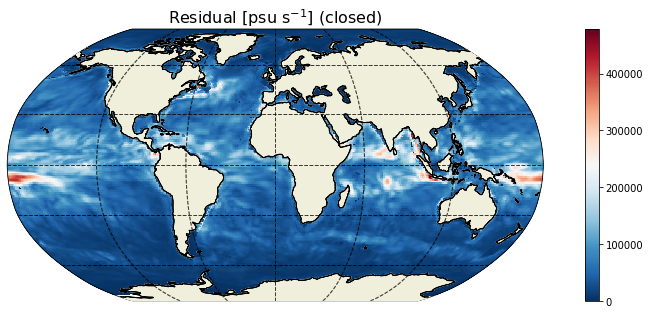

In [9]:
plt.figure(figsize=(15,5))
ecco_py.plot_proj_to_latlon_grid(coords.XC, coords.YC, res_closed_sum,
                                  show_colorbar=True, cmap='RdBu_r',dx=0.2, dy=0.2)
plt.title(r'Residual [psu s$^{-1}$] (closed)', fontsize=16)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1062: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


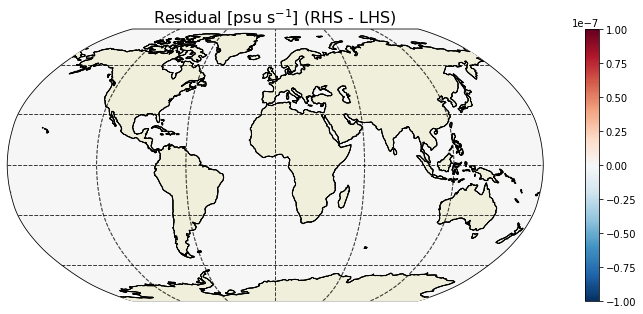

### Histogram of residuals

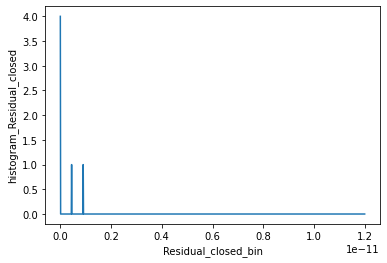

In [22]:
histogram(res_closed, bins = [np.linspace(0, 1.2e-11,1000)]).plot()

### Regridding
Regrid LLC dataset to regular 1/4 degree

In [12]:
#Regridding
from scipy.spatial import cKDTree
from itertools import product

In [13]:
tree = cKDTree(list(zip(coords.XC.values.flatten(),coords.YC.values.flatten())),balanced_tree=False)

# Spatial resolution
# Note: 1/4 degree is the default resolution in lon and lat to interpolate
dx = 0.25
dy = 0.25

# Longitude/latitude of regridded data
xt = np.linspace(-180+dx/2, 180-dx/2, int(360/dx))
yt = np.linspace(-90+dx/2, 90-dx/2, int(180/dy))
x, y = zip(*product(xt, yt))

d, inds = tree.query(list(zip(x, y)), k = 1)

In [14]:
mapxy = xr.DataArray(np.transpose(res_closed_sum.values.flatten()[inds].reshape(len(xt), len(yt))),
                     coords=[yt,xt],dims=['lat','lon'])

In [18]:
import cartopy

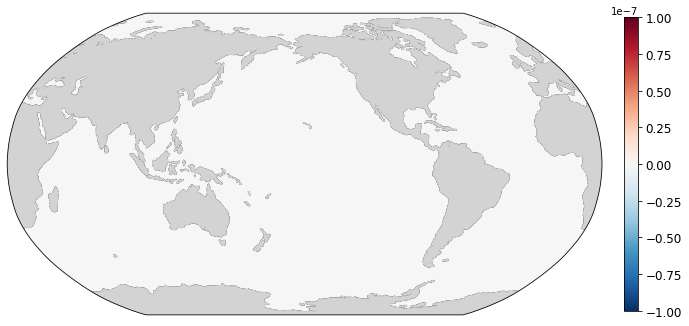

In [19]:
fig = plt.figure(figsize=(13,6))

ax = plt.axes(projection=cartopy.crs.Robinson(central_longitude=-159))
ax.set_global()
ax.coastlines(linewidth=1.0)
ax.add_feature(cartopy.feature.LAND,color='lightgrey', zorder=1)
    
p = ax.pcolormesh(mapxy.lon-0.125, mapxy.lat-0.125, mapxy, cmap='RdBu_r', vmin=-1e-7, vmax=1e-7, 
                  transform=cartopy.crs.PlateCarree(), zorder=0)

cb = fig.colorbar(p, orientation='vertical', shrink=0.9, pad = 0.03)
cb.ax.tick_params(labelsize=12)
plt.show()

### Integrate over ocean region

In [8]:
import shapely
import geopandas as gpd
import salem

In [9]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry']\
    .apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [10]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,-3.,51.917812,-3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [11]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [12]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https:

In [ ]:
# Create mask for SPNA
df = main.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('tile','j','i')
main['mask_spna'] = mask_spna.where(main.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('tile','j','i')
main['mask_nsea'] = mask_nsea.where(main.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('tile','j','i')
main['mask_lsea'] = mask_lsea.where(main.hFacC[0].values==1,0)

In [ ]:
# Salinity tendency (psu m^3/s)
tendSln_spna = (budgSln.tnd*main.mask_spna.where(main.mask_spna==1)).sum(dim=['tile','k','j','i'])

In [ ]:
# Salinity forcing (psu m^3/s)
forcSln_spna = (budgSln.frcSln*main.mask_spna.where(main.mask_spna==1)).sum(dim=['tile','k','j','i'])